In [1]:
# !pip install torch_geometric
# !pip install torch_scatter
# !pip install rdkit
# !pip install torch_sparse

In [2]:
import rdkit 
import torch 
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import seaborn as sns

from torch.nn import Linear
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.datasets import MoleculeNet 
from rdkit import Chem 
from rdkit.Chem.Draw import IPythonConsole
from torch_geometric.data import DataLoader 
from tqdm import tqdm 
from matplotlib import pyplot as plt 

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
data = MoleculeNet(root='./Data/', name='ESOL')
data

ESOL(1128)

In [5]:
print('Dataset type: ', type(data))
print('Dataset features: ', data.num_features)
print('Dataset target: ', data.num_classes)
print('Dataset length: ', data.len)
print('Dataset sample: ', data[0])
print('Sample nodes: ', data[0].num_nodes)
print('Sample edges: ', data[0].num_edges)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  734
Dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Sample nodes:  32
Sample edges:  68


In [6]:
data[0].x

tensor([[8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 0],
        [6, 0, 2, 5, 0, 0, 2, 0, 0],
        [7, 0, 1, 5, 0, 0, 2, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
 

In [7]:
data[0].edge_index.t()

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 2, 30],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 4, 26],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 7,  6],
        [ 7,  8],
        [ 7, 24],
        [ 8,  7],
        [ 8,  9],
        [ 9,  8],
        [ 9, 10],
        [ 9, 20],
        [10,  9],
        [10, 11],
        [11, 10],
        [11, 12],
        [11, 14],
        [12, 11],
        [12, 13],
        [13, 12],
        [14, 11],
        [14, 15],
        [14, 19],
        [15, 14],
        [15, 16],
        [16, 15],
        [16, 17],
        [17, 16],
        [17, 18],
        [18, 17],
        [18, 19],
        [19, 14],
        [19, 18],
        [20,  9],
        [20, 21],
        [20, 22],
        [21, 20],
        [22, 20],
        [22, 23],
        [22, 24],
        [23, 22],
        [24,  7],
        [24, 22],
        [24, 25],
        [2

In [8]:
data[0].y 

tensor([[-0.7700]])

In [9]:
data[0]['smiles']

'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '

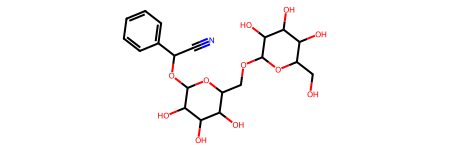

In [10]:
molecule = Chem.MolFromSmiles(data[0]['smiles'])
molecule

In [11]:
type(molecule)

rdkit.Chem.rdchem.Mol

In [12]:
embedding_size = 64 

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        
        # GCN Layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)
        # Output Layer
        self.out = Linear(embedding_size * 2, 1)
        
    def forward(self, x, edge_index, batch_index):
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
        
        hidden = torch.cat([gmp(hidden, batch_index), gap(hidden, batch_index)], dim=1)
        out = self.out(hidden)
        
        return out, hidden
    
model = GCN()
print(model)
print('Number of parameters: ', sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


In [13]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

model = model.to(device)

data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64 
train_loader = DataLoader(data[:int(data_size * 0.8)], batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):], batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

In [14]:
def train(data):
    for batch in train_loader:
        batch.to(device)
        optimizer.zero_grad()
        pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
        loss = loss_fn(pred, batch.y)
        loss.backward()
        optimizer.step()
    return loss, embedding

losses = []
for epoch in range(2000):
    loss, h = train(data)
    losses.append(loss)
    if (epoch + 1) % 50 == 0:
        print(f'Epoch {epoch + 1} | Train Loss {loss}')

Epoch 50 | Train Loss 0.5008953809738159
Epoch 100 | Train Loss 3.817232847213745
Epoch 150 | Train Loss 4.477048397064209
Epoch 200 | Train Loss 0.31493744254112244
Epoch 250 | Train Loss 0.28531137108802795
Epoch 300 | Train Loss 0.5402792096138
Epoch 350 | Train Loss 1.1283162832260132
Epoch 400 | Train Loss 1.1271215677261353
Epoch 450 | Train Loss 0.4696822166442871
Epoch 500 | Train Loss 0.20813708007335663
Epoch 550 | Train Loss 0.25656166672706604
Epoch 600 | Train Loss 0.14278650283813477
Epoch 650 | Train Loss 0.32519063353538513
Epoch 700 | Train Loss 0.07924691587686539
Epoch 750 | Train Loss 0.2094772309064865
Epoch 800 | Train Loss 0.38802406191825867
Epoch 850 | Train Loss 0.2484484165906906
Epoch 900 | Train Loss 0.14862971007823944
Epoch 950 | Train Loss 0.3201097249984741
Epoch 1000 | Train Loss 0.22668470442295074
Epoch 1050 | Train Loss 0.158726766705513
Epoch 1100 | Train Loss 0.15040355920791626
Epoch 1150 | Train Loss 0.25258883833885193
Epoch 1200 | Train Loss 0

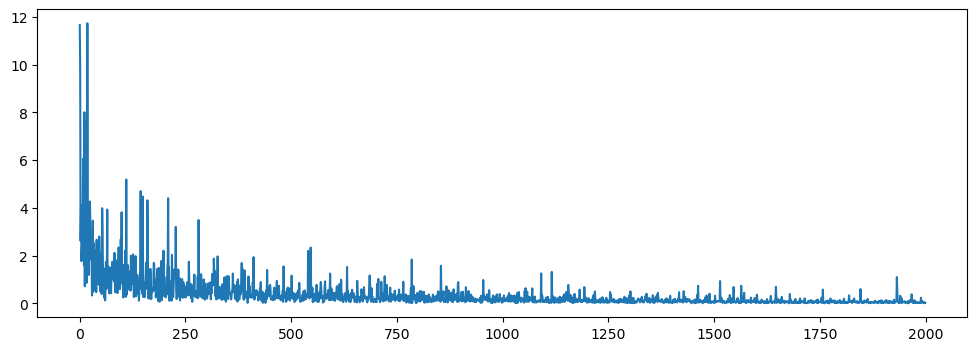

In [15]:
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
losses_indices = [i for i, l in enumerate(losses_float)]

plt.figure(figsize=(12, 4))
sns.lineplot(x=losses_indices, y=losses_float)
plt.show()

In [16]:
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embedding = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
    df = pd.DataFrame()
    df['y_real'] = test_batch.y.tolist()
    df['y_pred'] = pred.tolist()
df['y_real'] = df['y_real'].apply(lambda x: x[0])
df['y_pred'] = df['y_pred'].apply(lambda x: x[0])
df

,y_real,y_pred
0,0.940,0.726160
1,-6.237,-1.996058
2,-2.540,-2.835862
3,-5.680,-5.720804
4,-2.460,-1.689571
...,...,...
59,-1.890,-1.457266
60,-2.218,-4.295576
61,-3.583,-1.198488
62,-2.580,-2.593906


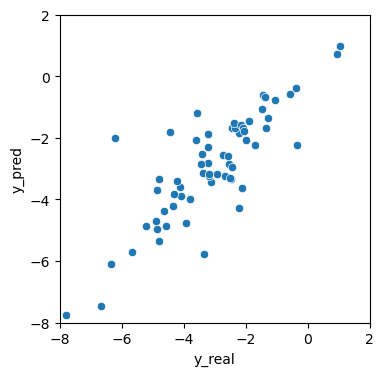

In [17]:
plt.figure(figsize=(4, 4))
sns.scatterplot(data=df, x='y_real', y='y_pred')
plt.xlim(-8, 2)
plt.ylim(-8, 2)
plt.show()